# Word embedding techniques

In this notebook I'll describe all the various word embedding techniques I've attempted in an effort to best map each company to an n-dimensional space where we can see distinct clusters between related companies.

## Table of contents

- [Data Pre-processing](#1-bullet)
- [Count Vectorizer](#2-bullet)
- [tf-idf (term frequency - inverse document frequency)](#3-bullet)
- [LDA (Latent Dirichlet Allocation)](#4-bullet)
- [LSA (Latent Semantic Analysis)](#5-bullet)
- [word2vec](#6-bullet)
- [doc2vec](#7-bullet)
- [accuracy](#8-bullet)

## Data Pre-processing <a class="anchor" id="1-bullet"></a>

The data we used is from the `bq_2018_top5SIC.json` file prepared by Professor Sotiros Damouras, by selecting companies who have filed in 2018 and belong to the top 5 industries within the dataset. This file has 1127 filings (one per company).

The file schema contains the columns:
- `accessionNumber`
- `filingDate`
- `reportingDate`
- `financialEntity`
- `htmlFile`
- `coDescription`
- `CIK`
- `name`
- `countryinc`
- `cityma`
- `SIC`
- `SIC_desc`

For our purposes, we will be focusing on `name` (identifies the company), `coDescription` (the Business Overview), `SIC_desc` (the industry they operate in)

Within our pre-processing, we focus on `coDescription`. 
- We removed any leftover HTML code which may interfere with our analysis and _"business overview"_ as it appears in almost all filings. 
- We lemmatized each cell (eg. am, are, is -> be) as they provide the same meaning, we don't want variations of a word to affect our analysis into sentiment
- Removed stop words (this, that, and, the, is etc.), punctuation and numbers, as they don't provide us semantic information either

In [1]:
import os
import json
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# nltk.download('stopwords')
# nltk.download('wordnet')

In [2]:
df = pd.read_json("bq_2018_top5SIC.json", lines = True)

#strip any left over html code
def clean_data_fn(insrt_data):
    clean_data = []
    for idx, ele in insrt_data.iterrows():
        if "https://www.sec.gov/Archives/edgar/data/" in ele["coDescription"]:
            pass
        else:
            clean_txt = re.compile('<.*?>')
            desc = re.sub(clean_txt,'',ele["coDescription"]).replace(u'\xa0', u' ').replace("   ", "").replace("'", "").replace('"','')
            if re.search('<', desc):
                pos = re.search('<', desc).start()
            desc = desc[:pos].lower()
            if (desc.find("business") >= 20): # didnt find it in the first 20 characters then look for next
                desc = desc[6 : ( desc.rfind("<") )] # remove the "Item 1." stuff only
            else: # found "business", remove everything before it
                desc =  desc[( desc.find("business") + 8 ) : ( desc.rfind("<") ) ]
            if (desc.find("overview") <= 20): # didnt find it in the first 20 characters then look for next
                desc =  desc[( desc.find("overview") + 8 ) :]
            # remove leading white space and periods
            desc = re.sub(r"^\.", "", desc).strip()            
            new_data = ele.copy()
            new_data["coDescription"] = desc
            # remove any filings with a description less than 250 characters (not enough information for us)
            if len(desc)<250:
                pass
            else:
                clean_data.append(new_data)
                
    return(pd.DataFrame(clean_data))

non_html_data = clean_data_fn(df)#.rename(columns = {"financialEntity":"CIK"})
non_html_data["CIK"] = non_html_data["CIK"].astype(int)

#lemmatization
lemmatizer = WordNetLemmatizer()
    
def lemmatize_sentence(sentence):
    lemmatized_output = [lemmatizer.lemmatize(w) for w in word_tokenize(sentence)]
    return " ".join(lemmatized_output)

lemma_desc = non_html_data["coDescription"].apply(lemmatize_sentence)
non_html_data["coDescription_lemmatized"] = lemma_desc
non_html_data["coDescription_lemmatized"].head()

# remove all numbers so they don't show up as dimensions
def remove_nums(x):
    text = x.lower()
    text = re.sub(r'\d+', '', text)
    return text

# remove stopwords and punctuation
def remove_stopwords(x):
    stop_words = set(stopwords.words('english'))

    word_tokens = word_tokenize(x)

    filtered_sentence = ' '.join([w for w in word_tokens if not w.lower() in stop_words and w.isalnum()])

    return(filtered_sentence)

rm_num_stopwords = non_html_data["coDescription_lemmatized"].apply(remove_nums).apply(remove_stopwords)
non_html_data["coDescription_stopwords"] = rm_num_stopwords

non_html_data.head()

accessionNumber               filingDate reportingDate  \
0  0001441816-18-000028  2018-03-30 20:12:23 UTC    2018-02-01   
1  0001108524-18-000011  2018-03-09 22:01:46 UTC    2018-02-01   
3  0001353283-18-000004  2018-03-30 21:21:46 UTC    2018-02-01   
4  0001660134-18-000007  2018-03-12 20:45:43 UTC    2018-02-01   
5  0001564590-18-007164  2018-03-29 21:34:05 UTC    2018-02-01   

                        financialEntity  \
0  financialEntities/params;cik=1441816   
1  financialEntities/params;cik=1108524   
3  financialEntities/params;cik=1353283   
4  financialEntities/params;cik=1660134   
5  financialEntities/params;cik=1393052   

                                            htmlFile  \
0  https://www.sec.gov/Archives/edgar/data/144181...   
1  https://www.sec.gov/Archives/edgar/data/110852...   
3  https://www.sec.gov/Archives/edgar/data/135328...   
4  https://www.sec.gov/Archives/edgar/data/166013...   
5  https://www.sec.gov/Archives/edgar/data/139305...   

                                       coDescription      CIK  \
0  mongodb is the leading modern, general purpose...  1441816   
1  salesforce is a global leader in customer rela...  1108524   
3  splunk provides innovative software solutions ...  1353283   
4  okta is the leading independent provider of id...  1660134   
5  veeva is a leading provider of industry cloud ...  1393052   

                 name countryinc         cityma   SIC  \
0       MONGODB, INC.         US       NEW YORK  7372   
1  SALESFORCE COM INC         US  SAN FRANCISCO  7372   
3          SPLUNK INC        NaN  SAN FRANCISCO  7372   
4          OKTA, INC.         US  SAN FRANCISCO  7372   
5   VEEVA SYSTEMS INC        NaN     PLEASANTON  7372   

                                            SIC_desc  \
0  Prepackaged Software (mass reproduction of sof...   
1  Prepackaged Software (mass reproduction of sof...   
3  Prepackaged Software (mass reproduction of sof...   
4  Prepackaged Software (mass reproduction of sof...   
5  Prepackaged Software (mass reproduction of sof...   

                            coDescription_lemmatized  \
0  mongodb is the leading modern , general purpos...   
1  salesforce is a global leader in customer rela...   
3  splunk provides innovative software solution t...   
4  okta is the leading independent provider of id...   
5  veeva is a leading provider of industry cloud ...   

                             coDescription_stopwords  
0  mongodb leading modern general purpose databas...  
1  salesforce global leader customer relationship...  
3  splunk provides innovative software solution e...  
4  okta leading independent provider identity ent...  
5  veeva leading provider industry cloud solution...

In [3]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.express as px

# Referenced from my CSCD25 course
def pca_visualize_2d(vectors, index):
    multi_index = pd.MultiIndex.from_frame(index, names=["name", "industry"])
    
    pca = PCA(n_components = min(10,vectors.shape[1]))
    pca_embedding = pca.fit_transform(vectors)
    pca_embedding = pd.DataFrame(pca_embedding, index = multi_index)
    
    fig = px.scatter(pca_embedding, x =0 , y = 1, hover_data={"name": pca_embedding.index.get_level_values(0),
                                                              "industry": pca_embedding.index.get_level_values(1)},
                     color = pca_embedding.index.get_level_values(1), width=1200, height=600)
    fig.show()
    
    return [pca, pca_embedding]

def pca_visualize_3d(plot):
    fig = px.scatter_3d(plot[1], x =0 , y = 1, z = 2, hover_data={"name": plot[1].index.get_level_values(0),
                                                              "industry": plot[1].index.get_level_values(1)},
                    color = plot[1].index.get_level_values(1), width=1200, height=600)
    fig.show()

## Count Vectorizer <a class="anchor" id="2-bullet"></a>

To start off our analysis, the simplest way to analyze our companies, we can just **count** the number of occurences of each word. We can augment this by counting **word sequences (n-grams)**, which include things like `cloud infrastructure`, `oil well`, or `life insurance`.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(ngram_range = (2,4), stop_words = 'english', max_features = 600)

cv_df = pd.DataFrame(cv.fit_transform(non_html_data["coDescription_stopwords"]).toarray())

In [5]:
# del cv

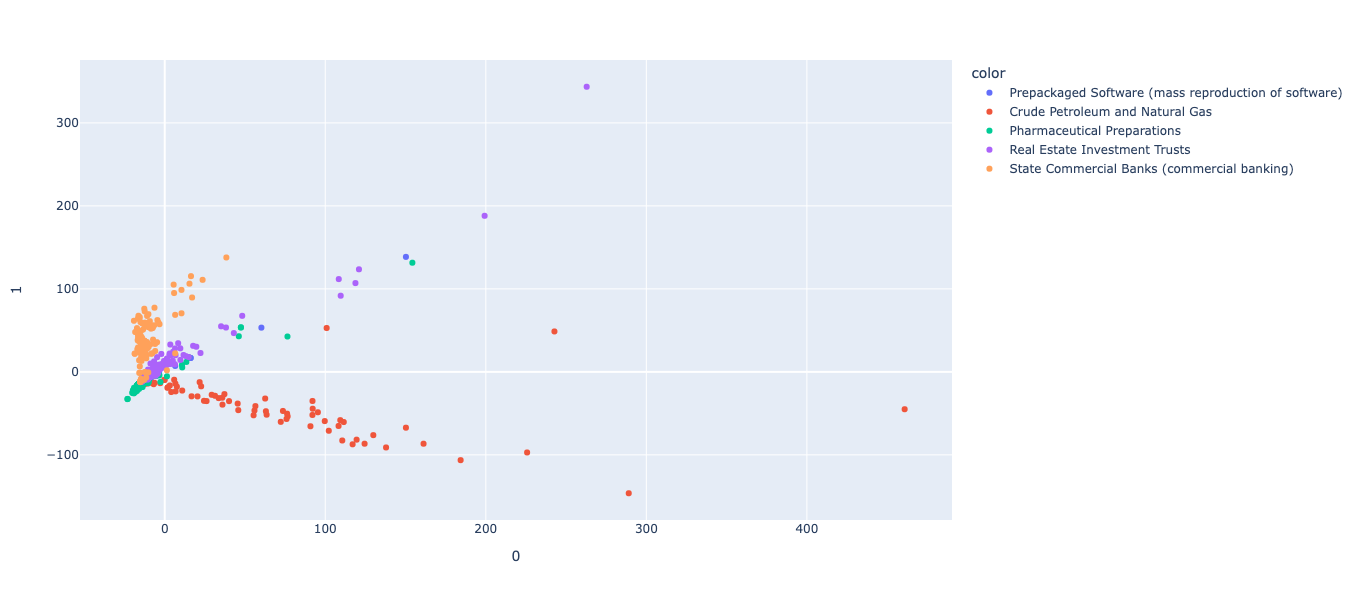

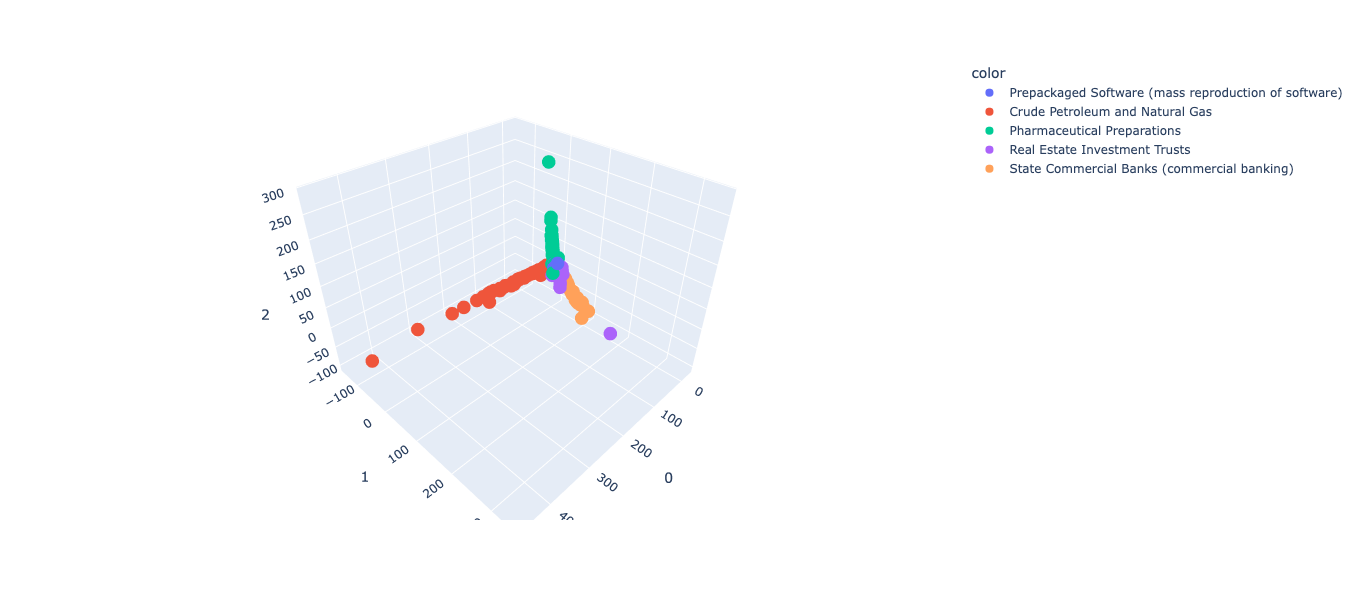

In [6]:
plot = pca_visualize_2d(cv_df, non_html_data.loc[:,["name","SIC_desc"]])
pca_visualize_3d(plot)

## tf-idf <a class="anchor" id="3-bullet"></a>

Now the problem with just looking at word/(n-grams) counts (term frequencies) is that very common words obviously have higher counts, which means certain dimensions would have a large influence on the final embedding. Words/terms like `accounting standards` or `financial statements` that commonly occur in financial reports such as these would carry huge weight, but not much semantic meaning. 

To solve this issue, we'll use something known as the `tf-idf`, which stands for `term-frequency - inverse document frequency`. 

\begin{align}
\text{tf-idf}(t,d) &= \text{tf}(t,d) \cdot \text{idf}(t,d)\\ \\
\text{Where: } \quad \text{tf}(t,d) &= |t| \text{ in } d\\ \\
\text{idf}(t,d) &= \log\frac{N}{\text{df}(t)}\\
\end{align}

- Where **t** is the current term we are process, and **d** is the current document we are looking in
- Where **N** is the total number of documents in the document set and **df(t)** is the document frequency of t;
    - The document frequency is the number of documents in the document set that contain the term t  
^ From [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)

tldr: **we give more weight to words that are less common among documents**

In [7]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

# combine the techniques since tf-idf only augments count vectorized documents
pipe = Pipeline([('count', CountVectorizer(ngram_range = (2,4), max_features = 600)),
                  ('tfidf', TfidfTransformer())]).fit(non_html_data["coDescription_stopwords"])

tfidf = pd.DataFrame(pipe.transform(non_html_data["coDescription_stopwords"]).toarray())

In [8]:
# del pipe

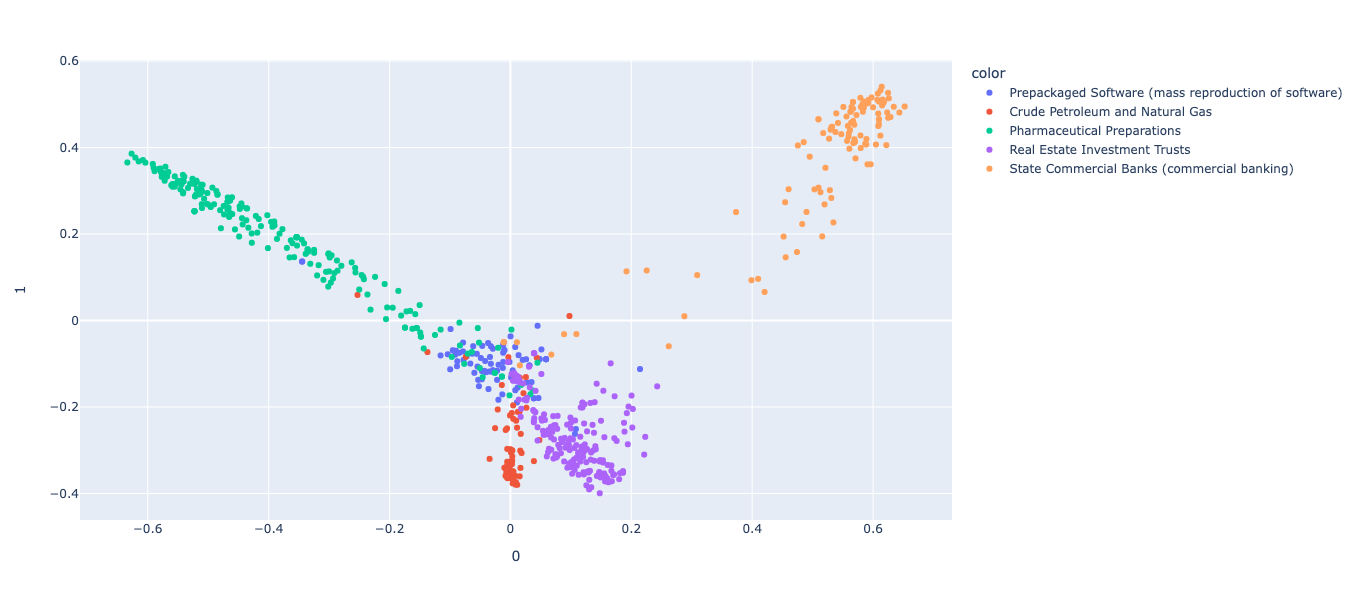

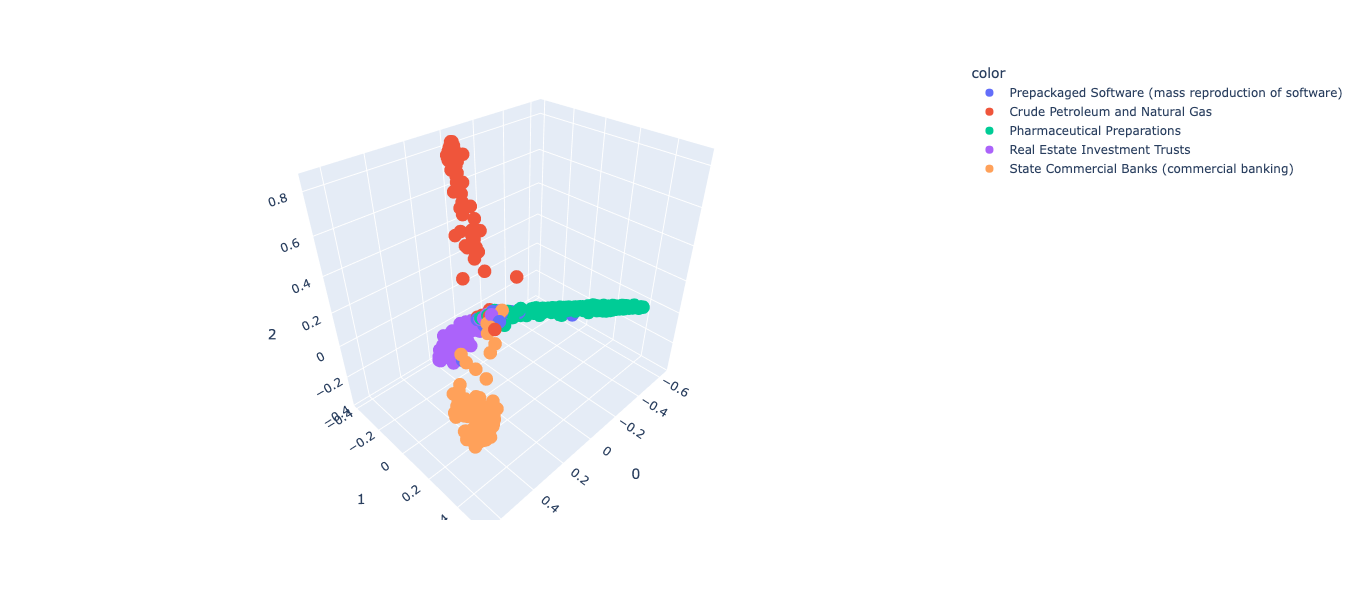

In [9]:
plot_tfidf = pca_visualize_2d(tfidf, non_html_data.loc[:,["name","SIC_desc"]])
pca_visualize_3d(plot_tfidf)

## LDA <a class="anchor" id="4-bullet"></a>

Now that we've looked at those techniques, we'll pivot a bit. Instead of just looking at how each document is related to the words in that document, we'll insert another layer into the analysis. We'll want to use the words to form "topics" and link documents to those topics. Perhaps this clutering technique will yield better clustering!

We are explaining documents (companies in our case) by their distribution across topics, which themselves are explained by a distribution of words

![image.png](images/lda.jpeg)

In [10]:
from sklearn.decomposition import LatentDirichletAllocation

#set the number of topics
n_components = 5

pipe_lda = Pipeline([('count', CountVectorizer(ngram_range = (2,5), max_features = 600)),
                 ('tfidf', TfidfTransformer()),
                 ('lda', LatentDirichletAllocation(n_components = n_components))]).fit(non_html_data["coDescription_stopwords"])

lda_df = pd.DataFrame(pipe_lda.transform(non_html_data["coDescription_stopwords"]))

In [11]:
# del pipe_lda

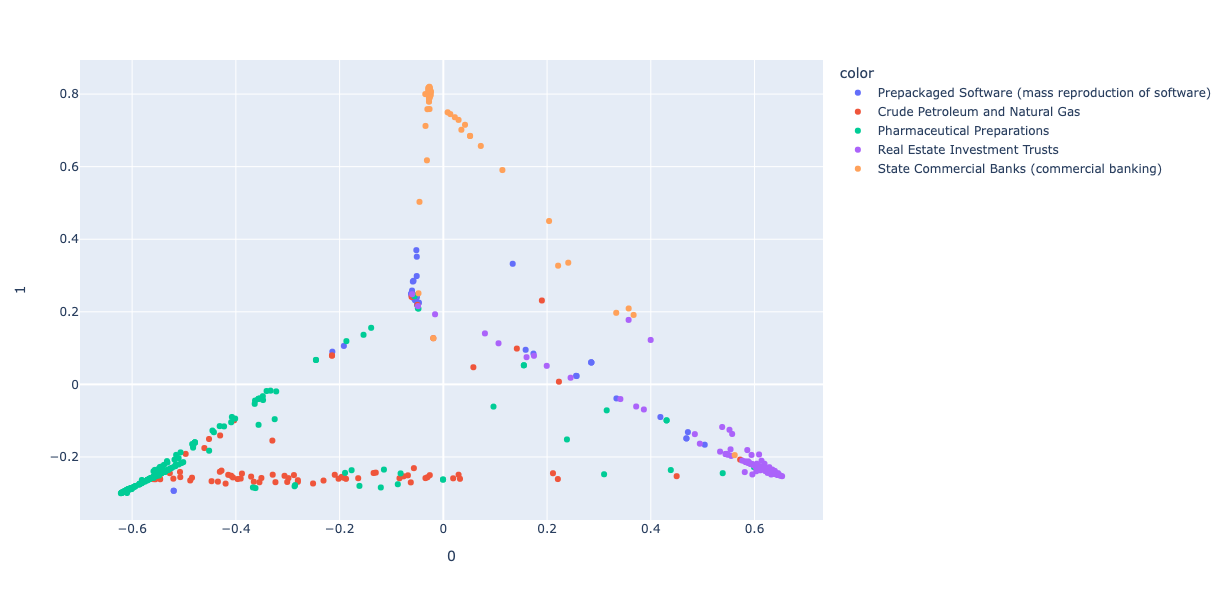

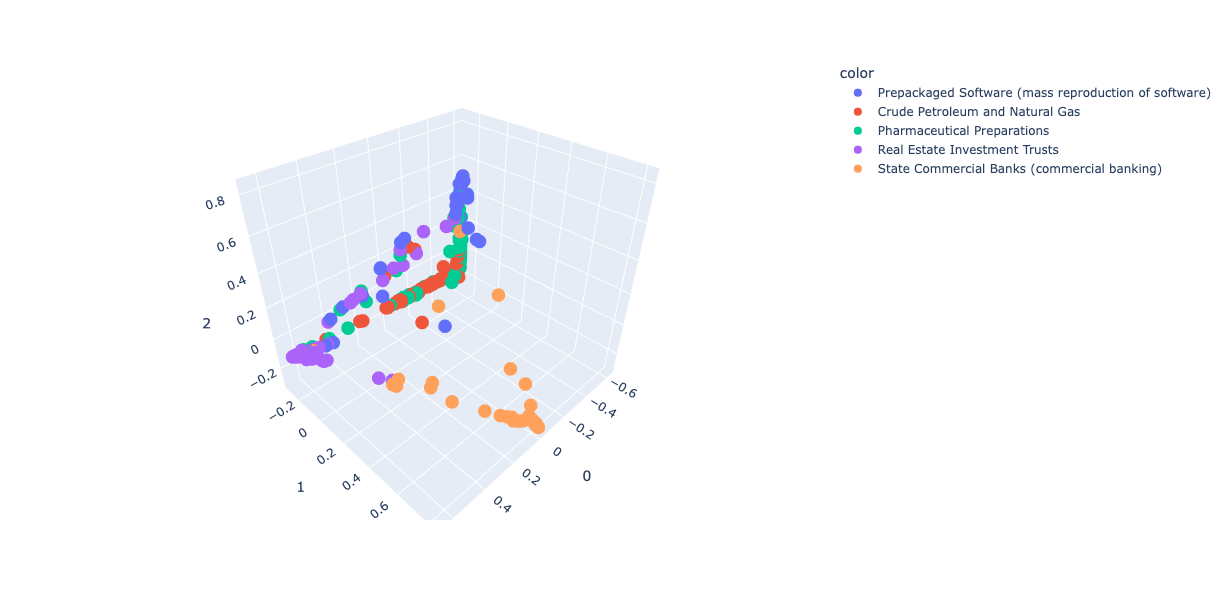

In [12]:
plot_lda = pca_visualize_2d(lda_df, non_html_data.loc[:,["name","SIC_desc"]])
pca_visualize_3d(plot_lda)

The shape of the 3d embedding forms a simplex as lda compresses our data into 5 topics (industries), and each company's vector represents their probability of belonging to each of the 5 topics.

**This particular 3d embedding only represents each companies probability of belonging to the first three topics**

In [13]:
# we can also look at the top 5 words per topic

lda_weights = pd.DataFrame(pipe_lda["lda"].components_, columns = pipe_lda["count"].get_feature_names_out())

lda_weights = lda_weights.melt(ignore_index = False).reset_index()

lda_weights.groupby('index').apply(lambda x:x.sort_values('value', ascending=False).iloc[0:5])

index               variable      value
index                                              
0     1525      0  intellectual property  15.729659
      815       0            data center  12.481026
      2450      0            report form  11.542497
      2505      0   research development  11.185306
      2910      0           united state  10.544482
1     611       1         company issued   0.200487
      2306      1         protection law   0.200401
      1606      1             lease term   0.200398
      1         1           ability make   0.200387
      1741      1         market product   0.200386
2     2372      2            real estate  52.335378
      2057      2  operating partnership  20.096310
      577       2           common stock  17.861096
      2717      2            square foot  17.688361
      1592      2          joint venture  16.586685
3     508       3         clinical trial  65.326557
      2248      3      product candidate  40.249161
      1913      3            natural gas  32.601531
      2178      3         phase clinical  24.907340
      2913      3           united state  23.025893
4     1429      4        holding company  41.304029
      249       4           bank holding  31.050159
      254       4   bank holding company  30.151896
      1154      4        federal reserve  24.261392
      1214      4  financial institution  16.599061

## LSA <a class="anchor" id="5-bullet"></a>

LSA stands for latent semantic analysis, also known as Truncated SVD. SVD stands for **Singular Value Decomposition**, which is a dimensionality reduction method like PCA (which we use to visualize our embeddings. It is used commonly in conjunction with tf-idf matrices. Contrary to PCA, SVD will not center the data before reducing dimensions, which makes it work better with sparse matrices (exactly what we have).

$$M=U*S*V$$

Where S is a diagonal matrix of the singular values of M. Critically, truncated SVD reduces dimensionality by selecting only the t largest singular values, and only keeping the first t columns of U and V. In this case, t is a hyperparameter we can select and adjust to reflect the number of topics we want to find.

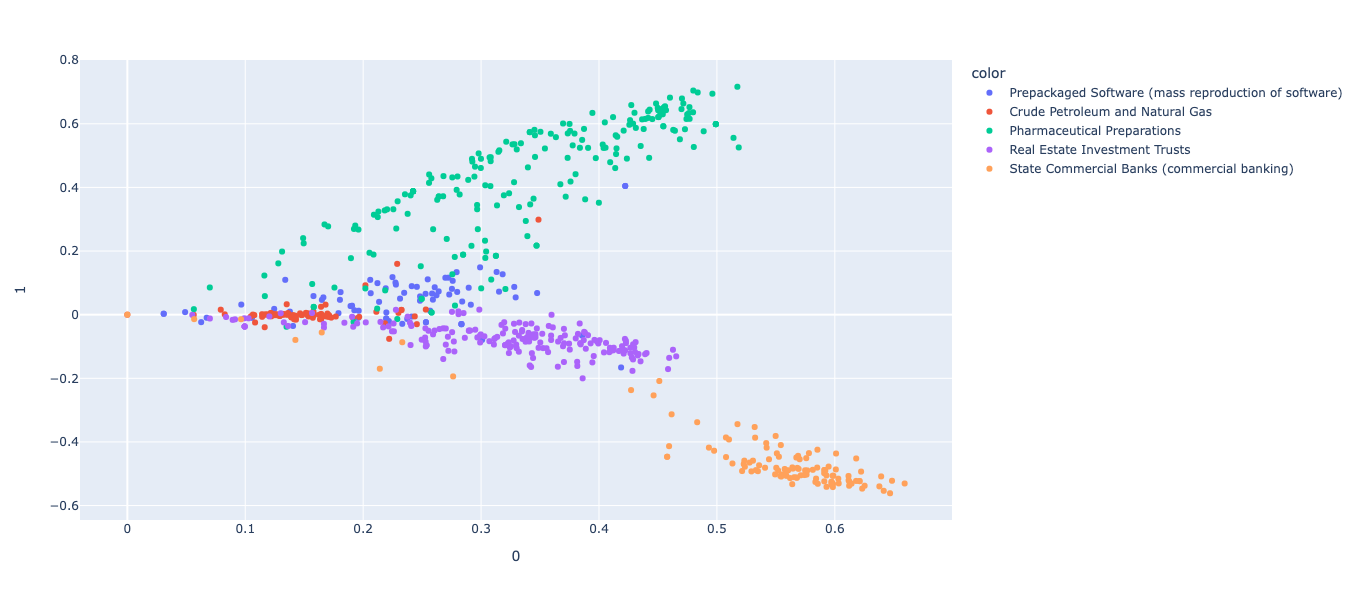

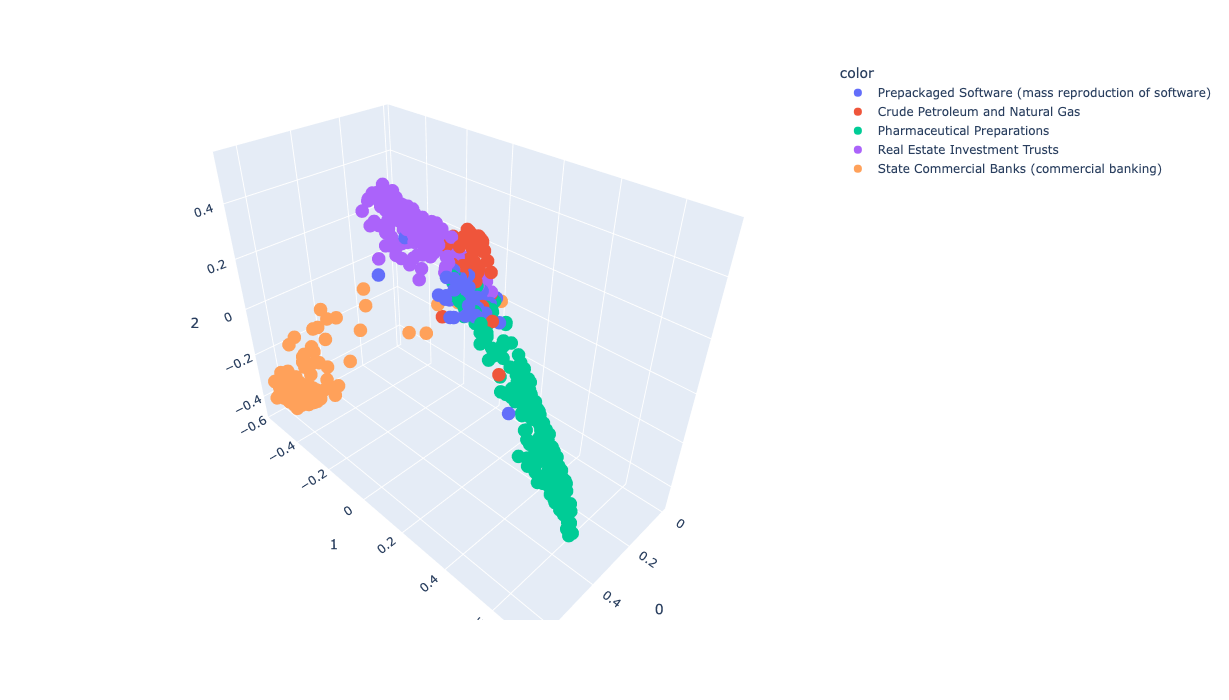

In [14]:
from sklearn.decomposition import TruncatedSVD

def visualize_svd(vectors, index):
    multi_index = pd.MultiIndex.from_frame(index, names=["name", "industry"])
    
    svd = TruncatedSVD(n_components = min(10,vectors.shape[1]))
    svd_embedding = svd.fit_transform(vectors)
    svd_embedding = pd.DataFrame(svd_embedding, index = multi_index)
    
    fig = px.scatter(svd_embedding, x =0 , y = 1, hover_data={"name": svd_embedding.index.get_level_values(0),
                                                              "industry": svd_embedding.index.get_level_values(1)},
                     color = svd_embedding.index.get_level_values(1), width=1200, height=600)
    fig.show()
    
    return [svd, svd_embedding]

plot_svd = visualize_svd(tfidf, non_html_data.loc[:,["name","SIC_desc"]])

fig = px.scatter_3d(plot_svd[1], x =0 , y = 1, z = 2, hover_data={"name": plot_svd[1].index.get_level_values(0),
                                                              "industry": plot_svd[1].index.get_level_values(1)},
                    color = plot_svd[1].index.get_level_values(1), width=1200, height=700)
fig.show()

This gives us a different way to represent the tf-idf matrix; it seems to do better at separating distinct clusters when compared th PCA.

## word2vec <a class="anchor" id="6-bullet"></a>

Word2Vec is a shallow neureal network with one hidden layer. This neural network can be constructed using two approaches. The *continuous bag of words (CBOW)* or *skip gram negative sampling* approach. 

CBOW takes in an input layer as large as the vocabulary of all the documents, and outputs a final probability score. For a given word, the input vector will give a value of 1 to words surrounding that word and a -1 to randomly sampled words far away from the word.

Skip gram negative sampling does the opposite, using a given word to predict it's surrounding words.

![image.png](images/word2vec.png)
![image.png](images/word2vec2.png)

In [15]:
from gensim.models.word2vec import Word2Vec
from gensim import utils

revs_processed = non_html_data["coDescription_stopwords"].apply(lambda x: utils.simple_preprocess(x))

model_w = Word2Vec(revs_processed, vector_size=200)

def doc_to_vec(text):
    word_vecs = [model_w.wv[w] for w in text if w in model_w.wv]
    
    if len(word_vecs) == 0:
        return np.zeros(model_w.vector_size)
    
    return np.mean(word_vecs, axis = 0)

doc_vec = pd.DataFrame(revs_processed.apply(doc_to_vec).tolist())


In [16]:
# del model_w

In [17]:
print(model_w.wv.most_similar(positive =['cloud'], topn = 5))

print(model_w.wv.most_similar(positive =['trial'], topn = 5))

print(model_w.wv.most_similar(positive =['oil'], topn = 5))

[('saas', 0.8366720080375671), ('server', 0.8196799755096436), ('architecture', 0.8195911645889282), ('computing', 0.8160094022750854), ('oracle', 0.8094568252563477)]
[('study', 0.8103083968162537), ('clinicaltrial', 0.7383608818054199), ('trialin', 0.6916875839233398), ('trials', 0.6858341097831726), ('clinicaltrials', 0.6533775925636292)]
[('oiland', 0.6909692287445068), ('natural', 0.6563162803649902), ('flared', 0.591386616230011), ('extractive', 0.5686981081962585), ('greenhouse', 0.5614648461341858)]


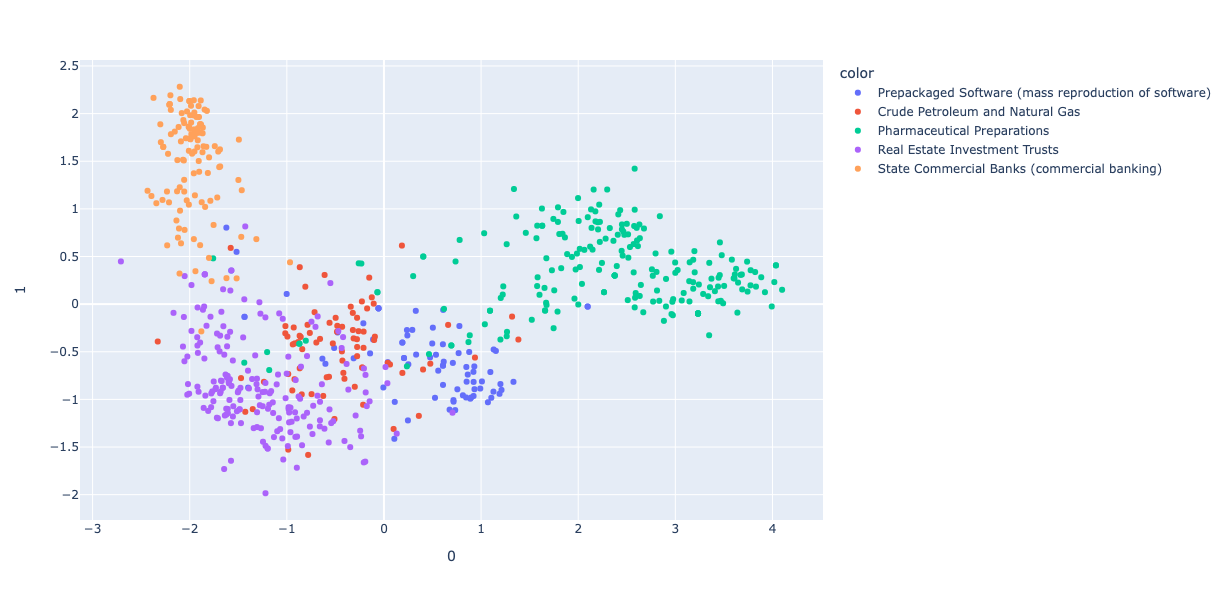

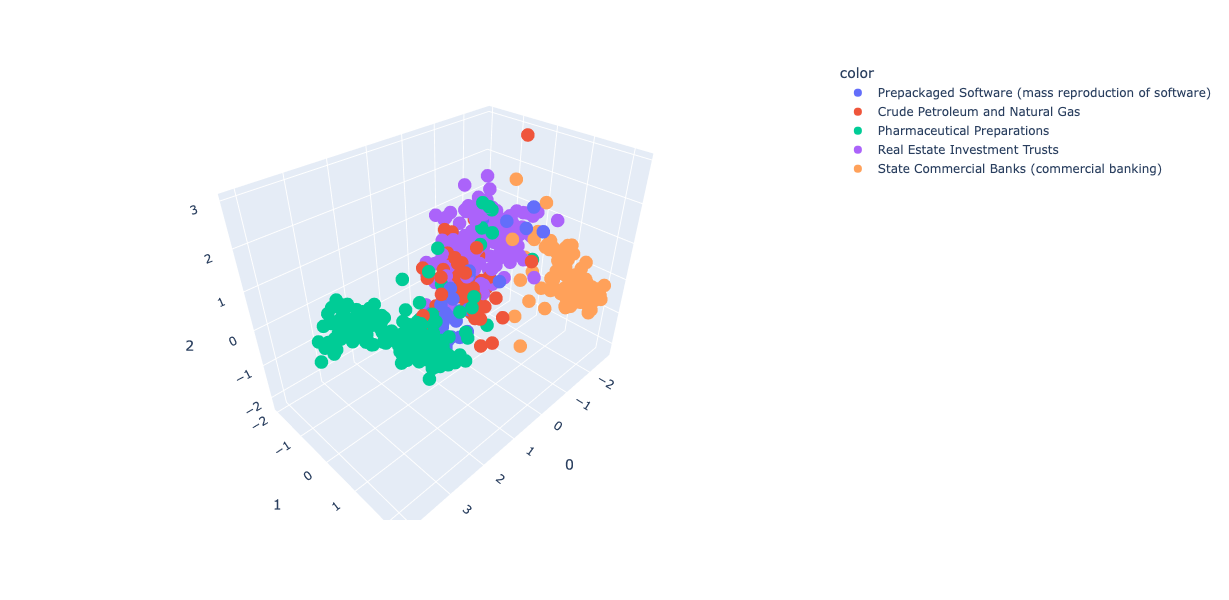

In [18]:
plot_w2v = pca_visualize_2d(doc_vec, non_html_data.loc[:,["name","SIC_desc"]])
pca_visualize_3d(plot_w2v)

## doc2vec <a class="anchor" id="7-bullet"></a>

This is an extension to word2vec, which an added input of the paragraph id (document id).

While the word vectors represent the concept of a word, the document vector intends to represent the concept of a document.

![image](images/doc2vec.png)

In [19]:
from gensim.models import doc2vec
from collections import namedtuple

docs = []
analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')
for i, text in enumerate(non_html_data["coDescription_stopwords"]):
    words = text.lower().split()
    tags = [i]
    docs.append(analyzedDocument(words, tags))

model = doc2vec.Doc2Vec(docs, vector_size = 100, window = 10, min_count = 1, workers = 4)

doc_vec_2 = pd.DataFrame([model.dv[doc] for doc in np.arange(0,len(docs))])

In [20]:
# del model

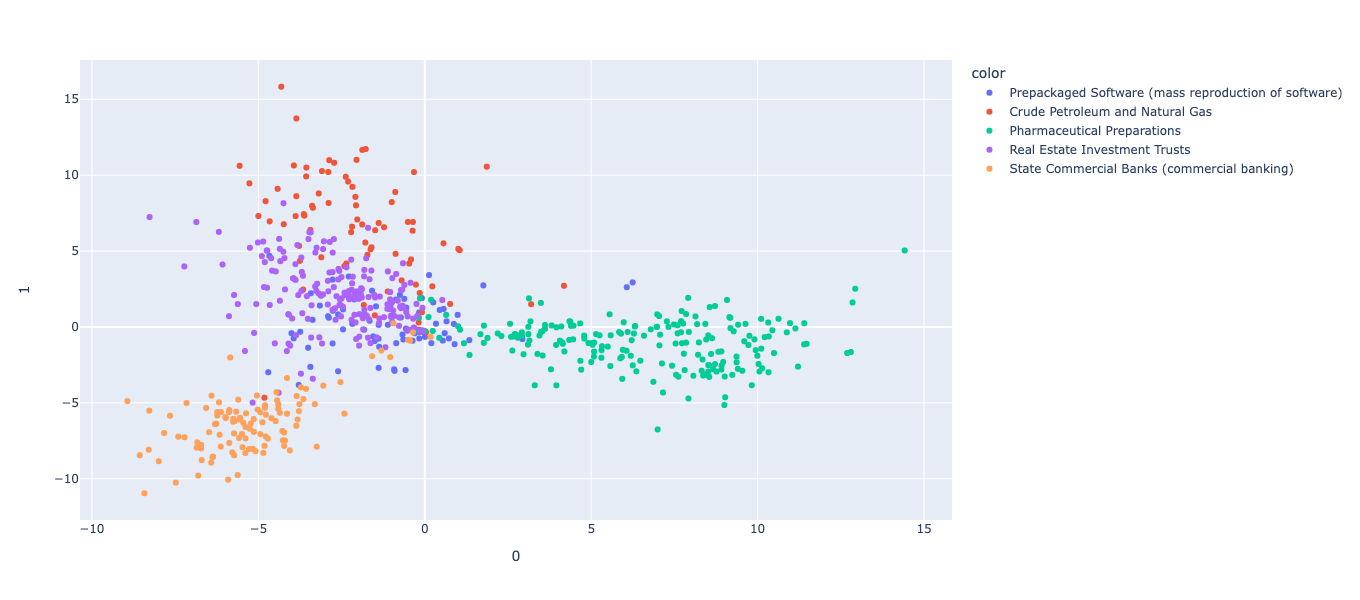

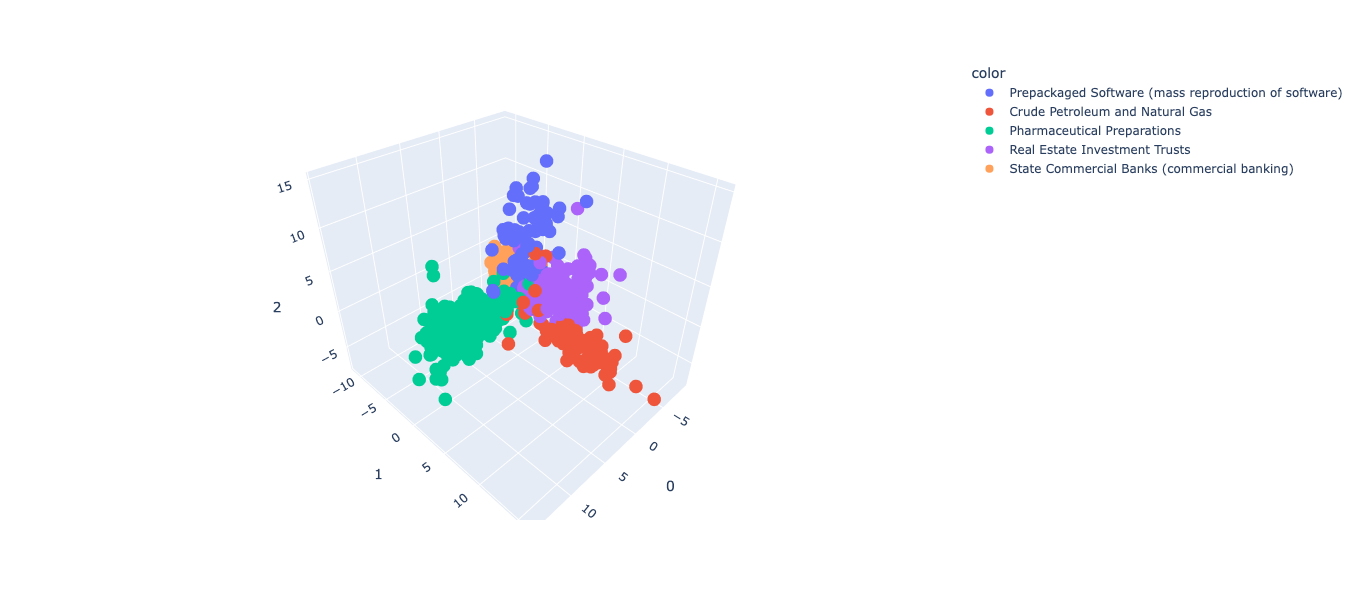

In [21]:
plot_d2v = pca_visualize_2d(doc_vec_2, non_html_data.loc[:,["name","SIC_desc"]])
pca_visualize_3d(plot_d2v)

## Accuracy  <a class="anchor" id="8-bullet"></a>

In [62]:
# matrices
# matrices = [cv_df, tfidf, lda_df, doc_vec, doc_vec_2]

In [84]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def dot_product(embedding_matrix):
    """calculates percentage of correct category predictions based on 1-NN using dot product
    
    args: embedding matrix of size nxm (n companies each with an embedding of size m). NOTE: embeddings should be normalized.
    
    returns: float representation of percentage of correct category predictions
    """
    dot_product = np.matmul(embedding_matrix, embedding_matrix.T)
    np.fill_diagonal(dot_product.values, 0)
    dot_product.index = non_html_data["SIC_desc"]
    dot_product.columns = non_html_data["SIC_desc"]
    dot_product_df = pd.DataFrame(dot_product.idxmax(axis=1))
    dot_product_df.reset_index(level=0, inplace=True)
    dot_product_df.columns = ["y_true", "y_pred"]
    return dot_product_df, np.sum(np.where(dot_product_df.iloc[:,1] == dot_product_df.iloc[:,0], 1, 0))/len(embedding_matrix), confusion_matrix(dot_product_df["y_true"], dot_product_df["y_pred"], labels=None, sample_weight=None, normalize='true')

def conf_mat(matrix):
    dot_product_df, accuracy, cm = dot_product(matrix)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=non_html_data["SIC_desc"].unique())
    disp.plot(xticks_rotation='vertical')
    
    return dot_product_df
    
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
def show_ROC_curves(df, similarity_matrix):
    for i in non_html_data["SIC_desc"].unique():
        y_true = similarity_matrix["y_true"] == i
        y_pred = similarity_matrix["y_pred"] == i
        fpr,tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)

        plt.plot(
            fpr,
            tpr,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc),
        )
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Some extension of Receiver operating characteristic to multiclass")
    plt.legend(loc="lower right")
    plt.show()

/var/folders/bv/fp_6_4x93dz06d5yzv0w3j8c0000gn/T/ipykernel_20692/3391328281.py:9: FutureWarning:

Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.



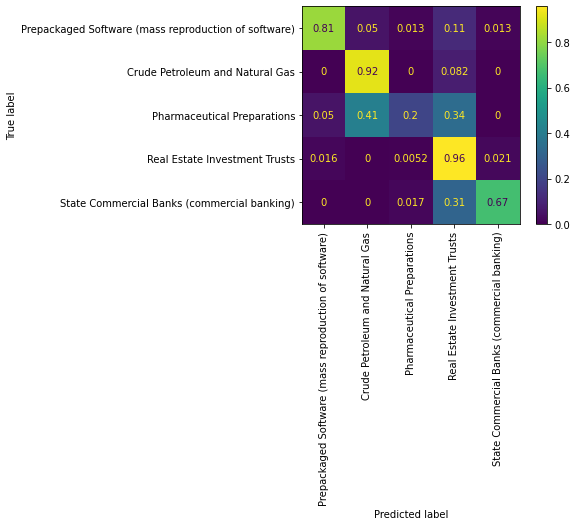

In [86]:
dp = conf_mat(cv_df)

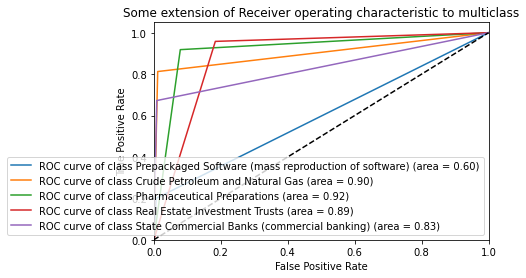

In [87]:
show_ROC_curves(cv_df, dp)

/var/folders/bv/fp_6_4x93dz06d5yzv0w3j8c0000gn/T/ipykernel_20692/3391328281.py:9: FutureWarning:

Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.



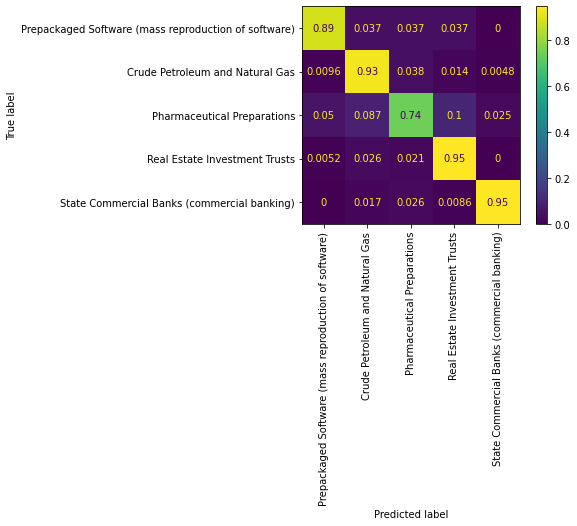

In [91]:
tf_dp = conf_mat(tfidf)

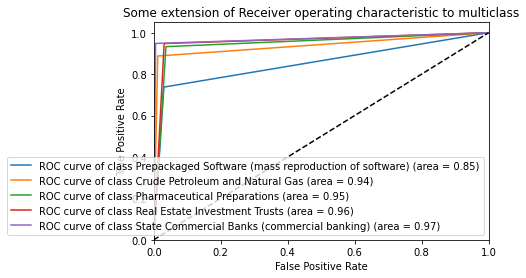

In [92]:
show_ROC_curves(tfidf, tf_dp)

/var/folders/bv/fp_6_4x93dz06d5yzv0w3j8c0000gn/T/ipykernel_20692/3391328281.py:9: FutureWarning:

Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.



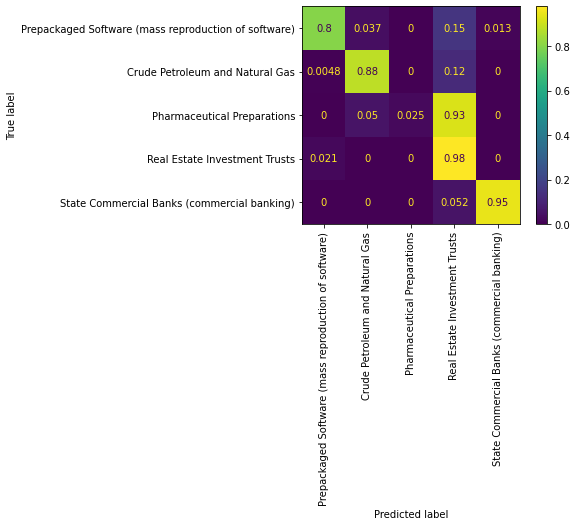

In [93]:
lda_dp = conf_mat(lda_df)

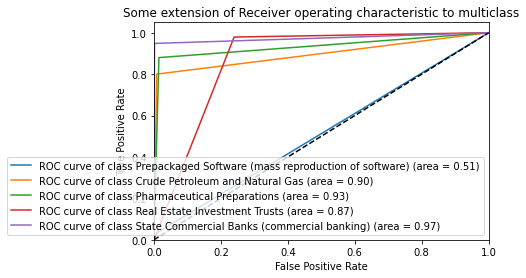

In [94]:
show_ROC_curves(lda_df, lda_dp)

/var/folders/bv/fp_6_4x93dz06d5yzv0w3j8c0000gn/T/ipykernel_20692/3391328281.py:9: FutureWarning:

Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.



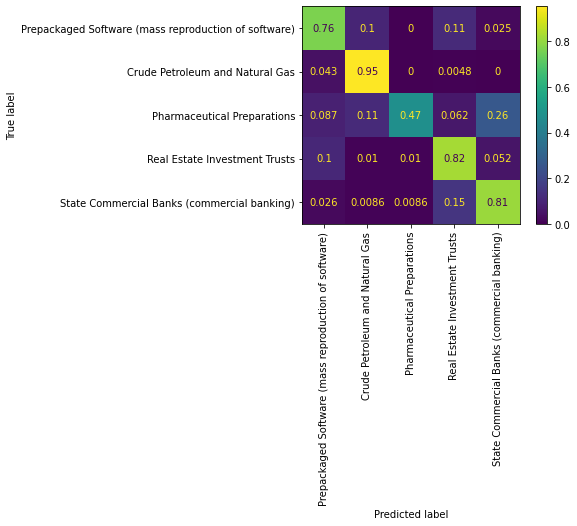

In [95]:
word_dp = conf_mat(doc_vec)

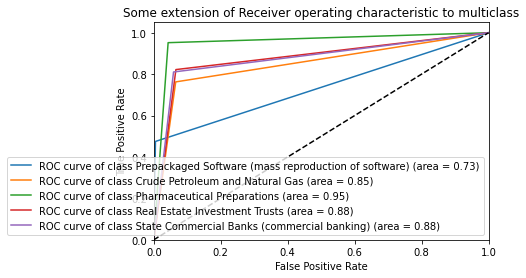

In [96]:
show_ROC_curves(doc_vec, word_dp)

/var/folders/bv/fp_6_4x93dz06d5yzv0w3j8c0000gn/T/ipykernel_20692/3391328281.py:9: FutureWarning:

Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.



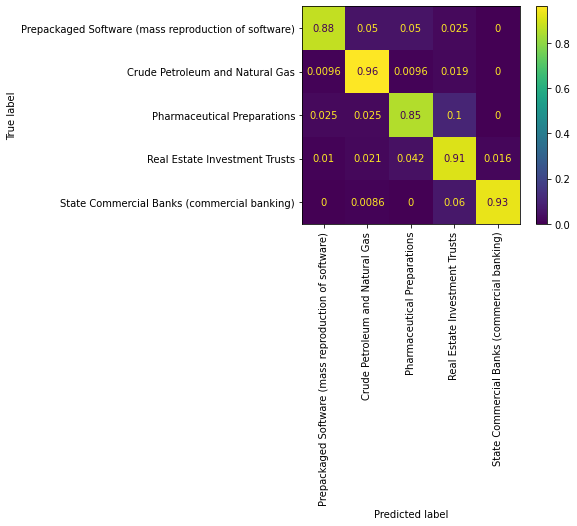

In [97]:
doc_dp = conf_mat(doc_vec_2)

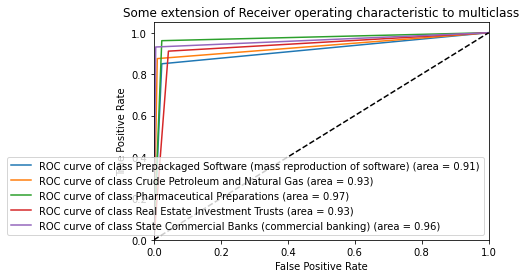

In [98]:
show_ROC_curves(doc_vec_2, doc_dp)